In [1]:
from ris import pysqldb
from IPython.display import Markdown, clear_output
from IPython.display import Image
from sqlalchemy import create_engine
import ris
import getpass
import datetime 
import pandas as pd
import numpy as np
import os
import requests

timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M')
ts = datetime.datetime.now().strftime('%Y-%m-%d')

Markdown('<strong>Notebook run on: {} | by {} | Using ris library version: {} | File Location: {}'.format(
    timestamp, getpass.getuser(), ris.__version__, os.getcwd()
))


<strong>Notebook run on: 2020-05-14 16:38 | by soge | Using ris library version: 1.4.7 | File Location: E:\RIS\Staff Folders\Samuel\Requests\SH\High_Bike_Crashes

In [2]:
try: 
    db.params['user']
    db2.params['user']
except:
    db = pysqldb.DbConnect(type='MS', server='dot55sql01', database='forms', user = 'arcgis', password = 'arcgis')
    db2 = pysqldb.DbConnect(type='PG', server='dotdevrhpgsql01', database='CRASHDATA')
    

	Missing SQL Server Native Client 10.0                 datetime2 will not be interpreted correctly

Database connection (MS) to forms on dot55sql01 - user: arcgis 
Connection established 2020-05-14 16:38:36
Query run in 1000 microseconds
	Missing SQL Server Native Client 10.0                 datetime2 will not be interpreted correctly


Additional database connection details required:
User name (crashdata):soge
Password (crashdata)········
Database connection (PG) to CRASHDATA on dotdevrhpgsql01 - user: soge 
Connection established 2020-05-14 16:38:41


### 1. Identify Corridors
#### Grabbing all distinct street names of street network and group their related segmentids.

In [3]:
db2.connect()

Database connection (PG) to CRASHDATA on dotdevrhpgsql01 - user: soge 
Connection established 2020-05-14 16:38:42


In [4]:
lion = db2.dfquery("""


SELECT * FROM (SELECT DISTINCT STREET
                   ,NODEIDFROM nodeid
                   ,masteridfrom masterid
                   ,CASE WHEN rboro = 1 or lboro = 1 THEN 'Manhattan' 
                         WHEN rboro = 2 or lboro = 2 THEN 'The Bronx'
                         WHEN rboro = 3 or lboro = 3 THEN 'Brooklyn'
                         WHEN rboro = 4 or lboro = 4 THEN 'Queens'
                         WHEN rboro = 5 or lboro = 5 THEN 'Staten Island' END borough
               FROM archive."19d.2020-03_16_lion"
               WHERE mft is not null
               ) nf

               UNION 

SELECT * FROM(SELECT DISTINCT STREET
                   ,NODEIDTO nodeid
                   ,masteridto masterid
                   ,CASE WHEN rboro = 1 or lboro = 1 THEN 'Manhattan' 
                         WHEN rboro = 2 or lboro = 2 THEN 'The Bronx'
                         WHEN rboro = 3 or lboro = 3 THEN 'Brooklyn'
                         WHEN rboro = 4 or lboro = 4 THEN 'Queens'
                         WHEN rboro = 5 or lboro = 5 THEN 'Staten Island' END borough
              FROM archive."19d.2020-03_16_lion"
              WHERE mft is not null
              ) nt


"""
)

### Centerline miles 
#### Grabbing all distinct street names of street network based on centerline segmentids.

In [5]:
miles = db2.dfquery("""

SELECT * FROM (SELECT DISTINCT STREET
                   ,SEGMENTID
                   ,NODEIDFROM nodeid
                   ,shape_length
                   ,CASE WHEN rboro = 1 or lboro = 1 THEN 'Manhattan' 
                         WHEN rboro = 2 or lboro = 2 THEN 'The Bronx'
                         WHEN rboro = 3 or lboro = 3 THEN 'Brooklyn'
                         WHEN rboro = 4 or lboro = 4 THEN 'Queens'
                         WHEN rboro = 5 or lboro = 5 THEN 'Staten Island' END borough
                   ,geom
               FROM archive."19d.2020-03_16_lion"
               WHERE mft is not null
               and rb_layer in ('G','B')
               ) nf

               UNION 

SELECT * FROM(SELECT DISTINCT STREET
                   ,SEGMENTID
                   ,NODEIDTO nodeid
                   ,shape_length
                   ,CASE WHEN rboro = 1 or lboro = 1 THEN 'Manhattan' 
                         WHEN rboro = 2 or lboro = 2 THEN 'The Bronx'
                         WHEN rboro = 3 or lboro = 3 THEN 'Brooklyn'
                         WHEN rboro = 4 or lboro = 4 THEN 'Queens'
                         WHEN rboro = 5 or lboro = 5 THEN 'Staten Island' END borough
                   ,geom
              FROM archive."19d.2020-03_16_lion"
              WHERE mft is not null
              and rb_layer in ('G','B')
              ) nt
ORDER BY SEGMENTID

""")

#### Calculating each corridor’s length (in centerline miles) 

In [6]:
mi = miles[['street','segmentid','shape_length','borough', 'geom']].drop_duplicates().reset_index().drop(columns=['index'])

In [7]:
miles_sum = mi.groupby(['street','borough'], as_index=False).sum().drop(columns = ['segmentid','geom'])
miles_sum['mileage'] = miles_sum.shape_length/5280

### 2. Collect injury data and group by corridor
#### Getting all of the intersection bike injuries in FORMS 

In [8]:
bike_inj = db.dfquery("""

SELECT nodeid, masterid, c.integration_id, count(distinct i.ROW_WID) bike_inj
FROM [FORMS].[dbo].[WC_ACCIDENT_F] as c
JOIN FORMS.dbo.WC_ACCIDENT_VICTIM_F as i
ON c.INTEGRATION_ID=i.ACCIDENT_ID
WHERE year(c.ACCIDENT_DT) between 2017 and 2019
AND i.INJ_KILLED = 'Injured'
AND coalesce(c.VOID_STATUS_CD , 'N') = 'N'
AND coalesce(nonmv, 0) = 0
AND i.PED_NONPED = 'Bicyclist'
GROUP BY nodeid, masterid,  c.integration_id



""")

	Missing SQL Server Native Client 10.0                 datetime2 will not be interpreted correctly



#### Removing all crashes without nodeids and masterids

In [9]:
bike_inj=bike_inj.loc[(bike_inj.nodeid.notnull())| (bike_inj.masterid.notnull())]

### 3. Join Bike Injury Crashes to LION

In [10]:
bike_inj['nodeid']=bike_inj.nodeid.fillna(0).astype('int64')
bike_inj['masterid']=bike_inj.masterid.fillna(0).astype('int64')
lion['nodeid'] = lion.nodeid.fillna(0).astype('int64')
lion['masterid'] = lion.masterid.fillna(0).astype('int64')

#### Joining lion to crashes based on nodeid

In [11]:
corr_inj_nodeid = lion.merge(bike_inj, on='nodeid', how = 'right')
corr_inj_nodeid['masterid']=corr_inj_nodeid['masterid_x'].fillna(0).astype('int64')
corr_inj_nodeid = corr_inj_nodeid.drop(columns = ['masterid_x','masterid_y'])

#### Joining lion to crashes based on masterid

In [12]:
corr_inj_masterid = lion.merge(bike_inj, on='masterid', how = 'right')
corr_inj_masterid['nodeid']=corr_inj_masterid.nodeid_x.fillna(0).astype('int64')
corr_inj_masterid = corr_inj_masterid.drop(columns = ['nodeid_x','nodeid_y'])

#### Concatenating both dataframes and filtering for distinct  street, borough, integration_id, bike_inj

In [13]:
corr_inj = pd.concat([corr_inj_nodeid,corr_inj_masterid]).drop_duplicates(subset=None, keep='first', inplace=False).reset_index().drop(columns=['index'])
corr_inj = corr_inj.loc[corr_inj.street.notnull()]
corr_inj = corr_inj[['street','borough','integration_id','bike_inj']]
corr_inj = corr_inj.drop_duplicates()

C:\Python27\ArcGIS10.4\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


### Calculate corridor bike injuries
#### Total injuries by corridor

In [14]:
ci = corr_inj.groupby(['street','borough'], as_index=False).sum()

#### Calculate corridor bike injuries by mile

In [16]:
inj_miles= ci.merge(miles_sum, on=['street','borough'], how='left')

In [17]:
inj_miles['inj_rate'] = (inj_miles.bike_inj/inj_miles.mileage).astype('float64')

In [18]:
inj_miles['mileage'] = pd.to_numeric(inj_miles.mileage)

In [19]:
inj_miles_geom = inj_miles.merge(mi, on=['street','borough'], how='left')

#### Setting injury rate threshold and grabbing segments

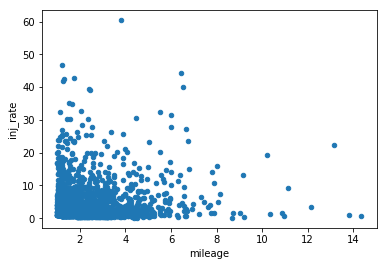

In [21]:
inj_miles.loc[inj_miles.mileage>1].plot(kind='scatter',x='mileage', y='inj_rate')

In [22]:
thresh = inj_miles.loc[inj_miles.inj_rate>15]
thresh_geom = thresh.merge(mi, on=['street','borough'], how='left')
#print(tuple(map(int,list(raw.loc[thresh_geom.mileage>1].segmentid))))

### Injury Rate Threshold = 15 inj/mile

#### Map of all corridors with greater than or equal to 15 injuries per mile

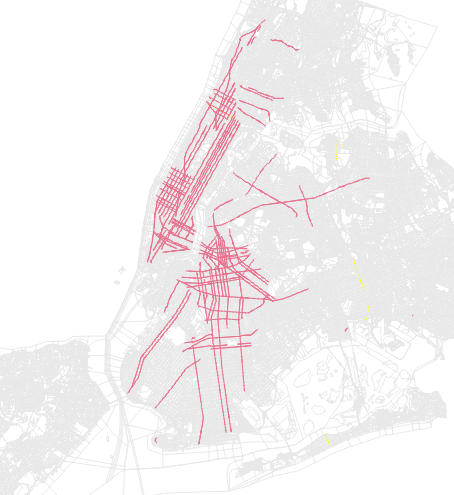

In [23]:
Image(filename="E:\RIS\Staff Folders\Samuel\Requests\SH\High_Bike_Crashes\high_bike_inj_cc.png")

### Corridor Statistics 

In [24]:
tot_stats = inj_miles.describe(include = 'all').fillna('NA')
#tot_stats

In [25]:
man_rate = inj_miles.loc[inj_miles.borough=='Manhattan']
bx_rate = inj_miles.loc[inj_miles.borough=='The Bronx']
bk_rate = inj_miles.loc[inj_miles.borough=='Brooklyn']
qns_rate = inj_miles.loc[inj_miles.borough=='Queens']
si_crate = inj_miles.loc[inj_miles.borough=='Staten Island']

In [26]:
man_stats=man_rate.describe(include = 'all').fillna('NA')
bx_stats=bx_rate.describe(include = 'all').fillna('NA')
bk_stats=bk_rate.describe(include = 'all').fillna('NA')
qns_stats=qns_rate.describe(include = 'all').fillna('NA')
si_stats=si_crate.describe(include = 'all').fillna('NA')

#### Export to excel

In [27]:
writer = pd.ExcelWriter('high_bike_crash_corr_{}.xlsx'.format(ts), engine='xlsxwriter')    
inj_miles.to_excel(writer, sheet_name='inj_miles', index= False)
inj_miles_geom.to_excel(writer, sheet_name='inj_miles_geom', index= False)
corr_inj.to_excel(writer, sheet_name='streets_w_intid', index= False)
tot_stats.to_excel(writer, sheet_name='stats')
man_stats.to_excel(writer, sheet_name='man_stats')
bx_stats.to_excel(writer, sheet_name='bx_stats')
bk_stats.to_excel(writer, sheet_name='bk_stats')
qns_stats.to_excel(writer, sheet_name='qns_stats')
si_stats.to_excel(writer, sheet_name='si_stats')
corr_inj.to_excel(writer, sheet_name='raw', index= False)
writer.save() 

In [28]:
inj_miles_geom.to_excel('inj_miles_geom.xlsx', index= False)